# Libraries
---

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import librosa.display as lib_display
import numpy as np

----
### Loading path-emotion csv into a dataframe
---

In [2]:
emotion_path_csv = os.path.abspath(os.path.join('Features',"Emotion_path_mapped.csv"))
df = pd.read_csv(emotion_path_csv,index_col=False).drop(["Unnamed: 0"],axis=1)
df.head(10)

,Emotion,Path
0,neutral,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
1,neutral,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
2,neutral,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
3,neutral,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
4,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
5,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
6,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
7,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
8,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...
9,calm,p:\TMSL\SEM3_Minor_Projet\Notebooks\Datasets\R...


### Emotion Count Graph
---
> to check if the data is balanced or not

C:\Users\PRITAM\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


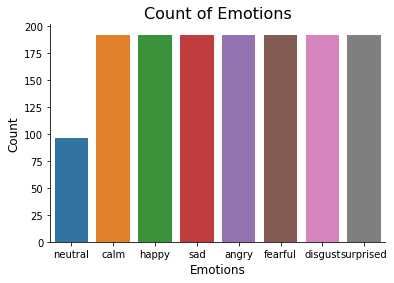

In [3]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

---
## Main Feature extraction function
---

In [4]:
def extract_features(data,sr):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    """
        path : path to the audio file 
        This returns n-darray of features with out data augmentation
    """
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    # print(f"Dim of Org Audio - {res1.ndim}, Len(Org Audio) - {len(res1)}")
    result = np.array(res1)
        
    return result

----
## Process of Feature Extraction
---

In [5]:
from tqdm.notebook import tqdm_notebook as prog_bar 


In [6]:
Features,Labels = [],[]
for emo,aud_path in prog_bar(zip(df.Emotion,df.Path),total=1440):
    aud_features = get_features(aud_path) #162 features per 3 audio [org, stretch, pitch]
    Features.append(aud_features)
    Labels.append(emo)

  0%|          | 0/1440 [00:00<?, ?it/s]

In [7]:
len(Features),len(Labels)

(1440, 1440)

In [8]:
Extracted_Features_DF = pd.DataFrame(Features)
Extracted_Features_DF['labels'] = Labels
Extracted_Features_DF.to_csv(os.path.join('Features','features_wo_augmentation.csv'), index=False)

----
# Load Feature into new df from csv
---

In [9]:
simple_feature_path = os.path.join('Features','features_wo_augmentation.csv')
df = pd.read_csv(simple_feature_path,index_col= False)

In [10]:
X = df.iloc[: ,:-1].values
Y = df['labels'].values
X,Y

(array([[3.00781250e-01, 7.06492245e-01, 7.56852806e-01, ...,
         5.37526876e-06, 2.27085820e-06, 1.64236539e-07],
        [2.71271882e-01, 6.74965560e-01, 7.23258853e-01, ...,
         8.46568582e-06, 2.63851257e-06, 1.78890204e-07],
        [3.07368526e-01, 7.16177821e-01, 7.61089087e-01, ...,
         2.48321940e-05, 8.08357254e-06, 6.46882143e-07],
        ...,
        [1.96438260e-01, 6.85374320e-01, 6.77751601e-01, ...,
         5.34026069e-04, 1.16256233e-04, 6.95794552e-06],
        [1.97600188e-01, 6.06160700e-01, 6.13527536e-01, ...,
         5.33638522e-03, 1.80294353e-03, 1.15872215e-04],
        [2.15621383e-01, 6.76596165e-01, 6.14103734e-01, ...,
         1.92967604e-03, 5.23758994e-04, 4.04801503e-05]]),
 array(['neutral', 'neutral', 'neutral', ..., 'surprised', 'surprised',
        'surprised'], dtype=object))

---
# Test Train Split
---

> #### import libraries

In [13]:
from sklearn.model_selection import train_test_split
import sys
from tqdm.notebook import tqdm_notebook as prog_bar

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### data spliting
---

In [15]:
random_states =( 10,13,17,24,51)
test_data_percentage = (.2,.25,.4,.5)
base_dir = os.path.abspath('Simple_Train_Test_Data_Splits')

for rs in random_states:
    if not os.path.isdir(os.path.join(base_dir,f"train_test_rs_{rs}")):
        os.mkdir(os.path.join(base_dir,f"train_test_rs_{rs}"))


base_filename = 'simple@TTS_'
extension = '.csv'

In [17]:
for rs in prog_bar(random_states):
    for per in prog_bar(test_data_percentage,total=len(test_data_percentage)):
        x_train, x_test,y_train, y_test = train_test_split(X,
                                            Y,
                                            shuffle=True,
                                            test_size=per,
                                            random_state=rs)
        
        #print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        
        train_df = pd.DataFrame(x_train)
        train_df['Y_train'] = y_train
        
        filename = base_filename+ 'train_' +str(round((1-per)*100))+"_"+str(round(per*100))+extension
        print(filename)
        train_df.to_csv(os.path.join(base_dir,f"train_test_rs_{rs}",filename),index=False)
        del filename
        
        test_df = pd.DataFrame(x_test)
        test_df['Y_test'] = y_test
        
        filename = base_filename+ 'test_' +str(round((1-per)*100))+"_"+str(round(per*100))+extension
        print(filename)
        test_df.to_csv(os.path.join(base_dir,f"train_test_rs_{rs}",filename),index=False)
        del filename
        
        del x_train
        del x_test
        del y_train
        del y_test
            

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

simple@TTS_train_80_20.csv
simple@TTS_test_80_20.csv
simple@TTS_train_75_25.csv
simple@TTS_test_75_25.csv
simple@TTS_train_60_40.csv
simple@TTS_test_60_40.csv
simple@TTS_train_50_50.csv
simple@TTS_test_50_50.csv


  0%|          | 0/4 [00:00<?, ?it/s]

simple@TTS_train_80_20.csv
simple@TTS_test_80_20.csv
simple@TTS_train_75_25.csv
simple@TTS_test_75_25.csv
simple@TTS_train_60_40.csv
simple@TTS_test_60_40.csv
simple@TTS_train_50_50.csv
simple@TTS_test_50_50.csv


  0%|          | 0/4 [00:00<?, ?it/s]

simple@TTS_train_80_20.csv
simple@TTS_test_80_20.csv
simple@TTS_train_75_25.csv
simple@TTS_test_75_25.csv
simple@TTS_train_60_40.csv
simple@TTS_test_60_40.csv
simple@TTS_train_50_50.csv
simple@TTS_test_50_50.csv


  0%|          | 0/4 [00:00<?, ?it/s]

simple@TTS_train_80_20.csv
simple@TTS_test_80_20.csv
simple@TTS_train_75_25.csv
simple@TTS_test_75_25.csv
simple@TTS_train_60_40.csv
simple@TTS_test_60_40.csv
simple@TTS_train_50_50.csv
simple@TTS_test_50_50.csv


  0%|          | 0/4 [00:00<?, ?it/s]

simple@TTS_train_80_20.csv
simple@TTS_test_80_20.csv
simple@TTS_train_75_25.csv
simple@TTS_test_75_25.csv
simple@TTS_train_60_40.csv
simple@TTS_test_60_40.csv
simple@TTS_train_50_50.csv
simple@TTS_test_50_50.csv
